# Problem

考虑某一股票的价格P，每过一段时间我们能获得一对数(t, Pt)，分别为当前的时间戳t和当前该股票的价格Pt，需要计算该股票在[t-W, t]时间段内的平均价格，
其中W是事先给定的窗口大小，单位和t相同。

请编写程序来实现这个计算过程。接口参见以下Interface节。

算法需要满足以下要求：

1. 相邻数据点之间的间隔不固定，可能有较大变化，在计算的时候应考虑数据间隔变化极端的情况下的鲁棒性;
2. 计算的平均价格应能较好反映股票价格在窗口时间内的“平均水平”
3. 假设在相邻两次数据到达期间内，股票的真实价格都等于前一次数据的价格
4. 所谓平均水平指的是股票价格在窗口内的简单移动平均（SMA）而不是指数移动平均（EMA）
5. 可用的内存大小是有限的，为O(num_bin)规模，当窗口内到达的数据量超过可用的存储空间时，应做一定的取舍，既不突破内存限制，又尽可能保证结果的精确性（只是简单地把尾部数据删除是不行的）
6. 实现以下MovingAverage接口
7. 尽量使用性能较优的算法和实现方法

编程语言：不限

# Note
====

num_bin: 使用的内存大小应为O(num_bin)级别
window：移动平均的窗口长度

timestamp是时间戳，浮点数，数据间隔不固定，可能一秒来几十个数据，也可能几小时来一个数据

# Code

## 程序代码

In [1]:
import numpy as np
class MovingAverage:
    def __init__(self, num_bin: int, window: float, precision="32bit"):
        self.intpre = np.uint8
        if(precision == "16bit"):
            self.precision = 16
            self.floatpre = np.float16
        elif(precision == "32bit"):
            self.precision = 32
            self.floatpre = np.float32
        elif(precision == "64bit"):
            self.precision = 64
            self.floatpre = np.float64
        elif(precision == "128bit"):
            self.precision = 128
            self.floatpre = np.float128
        else:
            self.precision = 64
            self.floatpre = np.float64
        self.queue = []
        self.max_len = num_bin*64//self.precision
        self.window = window

    def check(self, timestamp: float):
        # 检查是否有过期数据，有则删除
        tmp_time_stamp = self.floatpre(timestamp)
        del_idx = -1
        M = len(self.queue)
        for i in range(M):
            time = self.queue[i][0]
            if(time < tmp_time_stamp - self.window):
                del_idx = i
            else:
                break
        self.queue = self.queue[del_idx+1:]
    def merge(self):
        # 合并时间上最相邻的两个数据
        if(len(self.queue) == self.max_len):
            min_time_delta = 0x7fffffff
            M = len(self.queue)
            idx = -1
            for i in range(M - 1):
                time_delta = self.queue[i + 1][0] - self.queue[i][0]
                if(time_delta < min_time_delta):
                    min_time_delta = time_delta
                    idx = i
            fake_weight = (self.queue[idx][2] + self.queue[idx + 1][2])
            fake_time = (self.queue[idx][0]*self.queue[idx][2] + self.queue[idx + 1][0]*self.queue[idx + 1][2])/fake_weight
            fake_value = (self.queue[idx][1]*self.queue[idx][2] + self.queue[idx + 1][1]*self.queue[idx + 1][2])/fake_weight
            self.queue[idx] = (fake_time, fake_value, fake_weight)
            self.queue.pop(idx + 1)

    def Get(self) -> float:
        # 返回当前计算的平均值
        M = len(self.queue)
        sma = 0
        weight = 0
        for i in range(M):
            sma += self.queue[i][1]*self.queue[i][2]
            weight += self.queue[i][2]
        return sma/weight
        
    def Update(self, timestamp: float, value: float):
        # 新数据到达，更新状态
        self.check(timestamp)
        self.merge()
        tmp_tuple = (self.floatpre(timestamp), self.floatpre(value), self.intpre(1)) # (时间戳，值，权重)
        
        self.queue.append(tmp_tuple)


## 模拟数据实验

In [2]:
import numpy as np
np.random.seed(1024)

In [3]:
data_size = 1000
times = np.random.chisquare(1, data_size)
times = np.cumsum(times)
values = np.random.normal(10, 1, data_size)

In [4]:
def get_results(ma_robot, times, values, isprint=False):
    correct_num = 0
    mse = 0
    for i in range(data_size):
        sma = 0
        for j in range(i, -1, -1):
            if(times[i] - times[j] > W):
                sma = np.mean(values[j + 1:i + 1])
                break
            if(j == 0):
                sma = np.mean(values[:i + 1])
        
        ma_robot.Update(times[i], values[i])
        cal_sma = ma_robot.Get()
        mse += (sma - cal_sma)**2
        if(isprint):
            print("real_sma: %-20s cal_sma: %-20s"%(sma, cal_sma), end=" ")
        if(abs(sma - cal_sma) < 1e-2): # 由于股票数据本身的精度就只有小数点后2位，因此只要计算结果误差小于0.01就算对
            correct_num += 1
            if(isprint):
                print("correct!")
        else:
            if(isprint):
                print("wrong!")
    mse /= data_size
    if(isprint):
        print("correct rate = %-20s MSE = %-20s"%(correct_num/data_size, mse))

    return correct_num/data_size, mse

### 用float16存储的结果

In [5]:
W = 5
num_bin = 4
ma_robot = MovingAverage(num_bin, W, precision="16bit")
get_results(ma_robot, times, values, isprint=True)

real_sma: 9.774049408634541    cal_sma: 9.7734375            correct!
real_sma: 10.246851985717374   cal_sma: 10.24609375          correct!
real_sma: 9.751819715346498    cal_sma: 9.752604166666666    correct!
real_sma: 9.673540423703816    cal_sma: 9.673828125          correct!
real_sma: 9.77213905288551     cal_sma: 9.771875             correct!
real_sma: 9.969770199876853    cal_sma: 9.970052083333334    correct!
real_sma: 10.110963122647474   cal_sma: 10.111979166666666   correct!
real_sma: 8.833927214491649    cal_sma: 8.8359375            correct!
real_sma: 9.569015944040276    cal_sma: 9.5703125            correct!
real_sma: 10.14830752117654    cal_sma: 10.1484375           correct!
real_sma: 10.885973173675472   cal_sma: 10.885416666666666   correct!
real_sma: 10.791672058197545   cal_sma: 10.791015625         correct!
real_sma: 10.825991317572283   cal_sma: 10.825               correct!
real_sma: 10.76188116313707    cal_sma: 10.760416666666666   correct!
real_sma: 10.5980837

(0.884, 0.008333385350316892)

### 用float32存储的结果

In [6]:
W = 5
num_bin = 4
ma_robot = MovingAverage(num_bin, W, precision="32bit")
get_results(ma_robot, times, values, isprint=True)

real_sma: 9.774049408634541    cal_sma: 9.774049758911133    correct!
real_sma: 10.246851985717374   cal_sma: 10.246852397918701   correct!
real_sma: 9.751819715346498    cal_sma: 9.751819928487143    correct!
real_sma: 9.673540423703816    cal_sma: 9.673540592193604    correct!
real_sma: 9.77213905288551     cal_sma: 9.772139167785644    correct!
real_sma: 9.969770199876853    cal_sma: 9.969770272572836    correct!
real_sma: 10.110963122647474   cal_sma: 10.110963185628256   correct!
real_sma: 8.833927214491649    cal_sma: 8.833927631378174    correct!
real_sma: 9.569015944040276    cal_sma: 9.569016138712565    correct!
real_sma: 10.14830752117654    cal_sma: 10.14830748240153    correct!
real_sma: 10.885973173675472   cal_sma: 10.88597297668457    correct!
real_sma: 10.791672058197545   cal_sma: 10.791671991348267   correct!
real_sma: 10.825991317572283   cal_sma: 10.825991249084472   correct!
real_sma: 10.76188116313707    cal_sma: 10.761881033579508   correct!
real_sma: 10.5980837

(0.997, 9.2557998542412e-06)

### 用float64存储的结果

In [7]:
W = 5
num_bin = 4
ma_robot = MovingAverage(num_bin, W, precision="64bit")
get_results(ma_robot, times, values, isprint=True)

real_sma: 9.774049408634541    cal_sma: 9.774049408634541    correct!
real_sma: 10.246851985717374   cal_sma: 10.246851985717374   correct!
real_sma: 9.751819715346498    cal_sma: 9.751819715346498    correct!
real_sma: 9.673540423703816    cal_sma: 9.673540423703816    correct!
real_sma: 9.77213905288551     cal_sma: 9.77213905288551     correct!
real_sma: 9.969770199876853    cal_sma: 9.969770199876853    correct!
real_sma: 10.110963122647474   cal_sma: 10.110963122647474   correct!
real_sma: 8.833927214491649    cal_sma: 8.833927214491649    correct!
real_sma: 9.569015944040276    cal_sma: 9.569015944040276    correct!
real_sma: 10.14830752117654    cal_sma: 10.14830752117654    correct!
real_sma: 10.885973173675472   cal_sma: 10.885973173675472   correct!
real_sma: 10.791672058197545   cal_sma: 10.791672058197545   correct!
real_sma: 10.825991317572283   cal_sma: 10.825991317572285   correct!
real_sma: 10.76188116313707    cal_sma: 10.76188116313707    correct!
real_sma: 10.5980837

(0.894, 0.0037119643340262744)

### 用float128存储的结果

In [8]:
W = 5
num_bin = 4
ma_robot = MovingAverage(num_bin, W, precision="128bit")
get_results(ma_robot, times, values, isprint=True)

real_sma: 9.774049408634541    cal_sma: 9.774049408634541081 correct!
real_sma: 10.246851985717374   cal_sma: 10.24685198571737299 correct!
real_sma: 9.751819715346498    cal_sma: 9.75181971534649783  correct!
real_sma: 9.673540423703816    cal_sma: 9.673540423703816504 correct!
real_sma: 9.77213905288551     cal_sma: 9.772139052885509614 correct!
real_sma: 9.969770199876853    cal_sma: 9.969770199876852423 correct!
real_sma: 10.110963122647474   cal_sma: 10.083177899165070457 wrong!
real_sma: 8.833927214491649    cal_sma: 8.833927214491649416 correct!
real_sma: 9.569015944040276    cal_sma: 9.56901594404027674  correct!
real_sma: 10.14830752117654    cal_sma: 9.9133381067565484734 wrong!
real_sma: 10.885973173675472   cal_sma: 10.809363058944443381 wrong!
real_sma: 10.791672058197545   cal_sma: 10.709164943217551524 wrong!
real_sma: 10.825991317572283   cal_sma: 10.772690796180972583 wrong!
real_sma: 10.76188116313707    cal_sma: 10.706418715136980069 wrong!
real_sma: 10.5980837475273

(0.368, 0.04992029092428399339)

## 结果比较

In [9]:
import matplotlib.pyplot as plt

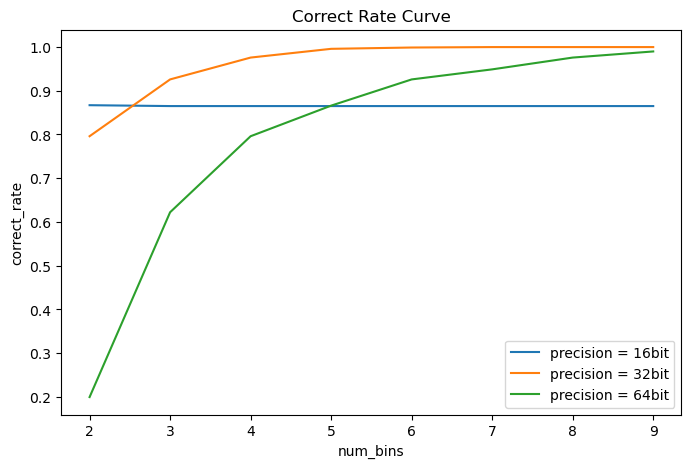

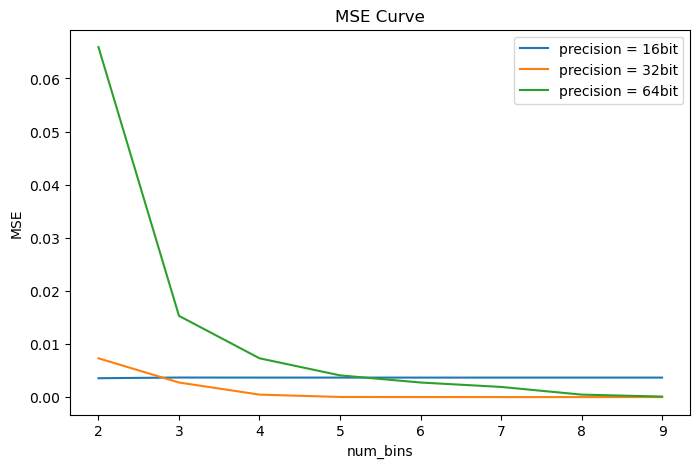

In [10]:
bits = ["16bit", "32bit", "64bit"]
W = 7
plt.figure(figsize=(8, 5))
plt.title("Correct Rate Curve")
for i, precision in enumerate(bits):
    num_bins = np.arange(2, 10, 1)
    correct_rates = []
    mses = []
    for num_bin in num_bins:
        ma_robot = MovingAverage(num_bin, W, precision=precision)
        correct_rate, mse = get_results(ma_robot, times, values)
        correct_rates.append(correct_rate)
        mses.append(mse)
    plt.plot(num_bins, correct_rates, "-", label="precision = %s"%(precision))
plt.xlabel("num_bins")
plt.ylabel("correct_rate")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.title("MSE Curve")
for i, precision in enumerate(bits):
    num_bins = np.arange(2, 10, 1)
    correct_rates = []
    mses = []
    for num_bin in num_bins:
        ma_robot = MovingAverage(num_bin, W, precision=precision)
        correct_rate, mse = get_results(ma_robot, times, values)
        correct_rates.append(correct_rate)
        mses.append(mse)
    plt.plot(num_bins, mses, "-", label="precision = %s"%(precision))
plt.xlabel("num_bins")
plt.ylabel("MSE")
plt.legend()
plt.show()

可见，使用32-bit精度存储是最优的